In [36]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from subprocess import check_output
from plotly import __version__
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

## Reading the raw data into a dataframe

In [2]:
df = pd.read_csv('us_perm_visas.csv', low_memory = False, parse_dates=['decision_date', 'case_received_date'],\
                 index_col = ['case_no'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374362 entries, A-07323-97014 to nan
Columns: 153 entries, add_these_pw_job_title_9089 to wage_offered_unit_of_pay_9089
dtypes: datetime64[ns](2), float64(10), object(141)
memory usage: 439.8+ MB


In [4]:
#Removing all withdrawn applications
df = df[df.case_status != 'Withdrawn']

#Combining certified-expired and certified applications
df.loc[df.case_status == 'Certified-Expired', 'case_status'] = 'Certified'

df.loc[df.case_status == 'Certified', 'case_status'] = 1
df.loc[df.case_status == 'Denied', 'case_status'] = 0

In [5]:
df['year'] = df['case_received_date'].dt.year

In [6]:
#Dropping all empty columns
df = df.dropna(axis=1, how='all');

#Dropping all empty rows
df = df.dropna(axis=0, how='all');

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356168 entries, A-07323-97014 to nan
Columns: 154 entries, add_these_pw_job_title_9089 to year
dtypes: datetime64[ns](2), float64(11), int64(1), object(140)
memory usage: 421.2+ MB


In [7]:
#Dropping all rows with any missing values
df_nona = df.dropna(axis=0, how='any');

df_nona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 154 entries, add_these_pw_job_title_9089 to year
dtypes: datetime64[ns](2), float64(11), int64(1), object(140)
memory usage: 0.0+ bytes


## Visualisation of the data

In [8]:
pd.set_option('display.max_colwidth', -1)

In [9]:
i = 0
count_nonnan = [];
ct = [];

for col in df.columns:
    i+=1
    count_nonnan.append(df[col].count())
    ct.append(i)

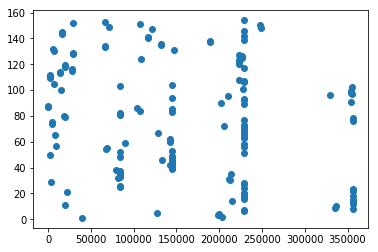

In [10]:
plt.scatter(count_nonnan, ct)

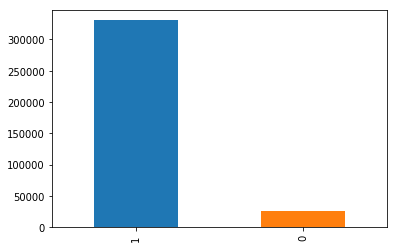

In [11]:
df['case_status'].value_counts().plot(kind = 'bar')

There are 201 different countries of citizenship in this dataset


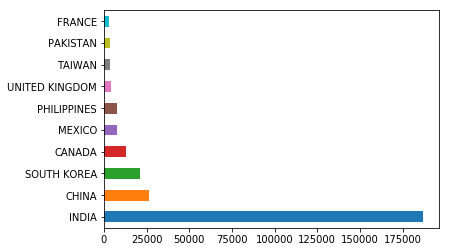

In [12]:
print('There are', df['country_of_citizenship'].value_counts().count(), \
      'different countries of citizenship in this dataset')
df['country_of_citizenship'].value_counts().head(10).plot(kind = 'barh')

C:\Users\Asavari\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



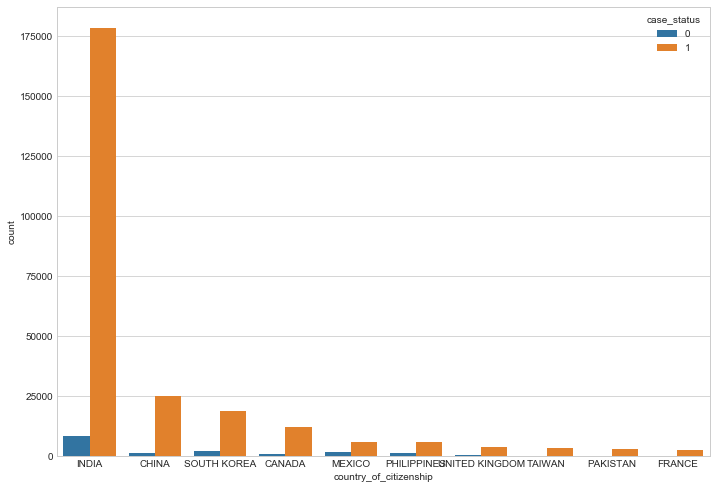

In [13]:
sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(ax = ax, x='country_of_citizenship', data = df, hue='case_status', \
              order=df.country_of_citizenship.value_counts().iloc[:10].index)#, palette=pkmn_type_colors)

In [14]:
#ue_wide = df.pivot(index = 'country_of_citizenship', columns = 'year', values = 'case_status')
#sns.heatmap(ue_wide)

In [15]:
#series = df['country_of_citizenship'].value_counts()[:10]
#series.iplot(kind='bar', yTitle='Number of Applications', title='blah')

## Feature Selection

In [16]:
#Displaying percentage of non-null values for each feature

i = 0;
for col in df.columns:
    i = i+1;
    print (i-1, col, 100*df[col].count()/len(df['case_status']))

0 add_these_pw_job_title_9089 10.9883538106
1 agent_city 56.91583747
2 agent_firm_name 55.7383032726
3 agent_state 56.0477078233
4 application_type 35.6146537589
5 case_number 64.3853462411
6 case_received_date 64.3853462411
7 case_status 100.0
8 class_of_admission 94.0800408796
9 country_of_citizenship 94.5890703264
10 country_of_citzenship 5.39548752274
11 decision_date 100.0
12 employer_address_1 99.9896116439
13 employer_address_2 60.4046405067
14 employer_city 99.9971923362
15 employer_country 64.3651310617
16 employer_decl_info_title 64.374957885
17 employer_name 99.997753869
18 employer_num_employees 64.3637272298
19 employer_phone 64.3755194178
20 employer_phone_ext 6.31668201523
21 employer_postal_code 99.9907347095
22 employer_state 99.9896116439
23 employer_yr_estab 64.3477235462
24 foreign_worker_info_alt_edu_experience 23.6643943308
25 foreign_worker_info_birth_country 23.6652366299
26 foreign_worker_info_city 64.3777655488
27 foreign_worker_info_education 64.3743963523
28

In [17]:
#Finding relation between case received date and decision date
df[['case_received_date', 'decision_date']]

,case_received_date,decision_date
case_no,,
A-07323-97014,NaT,2012-02-01
A-07332-99439,NaT,2011-12-21
A-07333-99643,NaT,2011-12-01
A-07339-01930,NaT,2011-12-01
A-07345-03565,NaT,2012-01-26
A-07352-06288,NaT,2012-01-26
A-07354-06926,NaT,2011-10-07
A-08004-10147,NaT,2012-02-06
A-08004-10184,NaT,2012-02-29


In [18]:
#Indices of selected features
a = [2,3,7,8,9,11,14,15,17,18,21,22,23,75,77,90,96,98,101];

df2 = df.iloc[:,a];

df2 = df2.dropna(thresh=0.5*len(df), axis=1);

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356168 entries, A-07323-97014 to nan
Data columns (total 19 columns):
agent_firm_name           198522 non-null object
agent_state               199624 non-null object
case_status               356168 non-null int64
class_of_admission        335083 non-null object
country_of_citizenship    336896 non-null object
decision_date             356168 non-null datetime64[ns]
employer_city             356158 non-null object
employer_country          229248 non-null object
employer_name             356160 non-null object
employer_num_employees    229243 non-null float64
employer_postal_code      356135 non-null object
employer_state            356131 non-null object
employer_yr_estab         229186 non-null float64
job_info_work_city        356073 non-null object
job_info_work_state       356072 non-null object
pw_amount_9089            353965 non-null object
pw_soc_code               355778 non-null object
pw_source_name_9089       354081 non-null o

### Selected Features

In [19]:
#Displaying percentage of non-null values for each selected feature

i = 0;
for col in df2.columns:
    i = i+1;
    print (i-1, col, 100*df2[col].count()/len(df2['case_status']))

0 agent_firm_name 55.7383032726
1 agent_state 56.0477078233
2 case_status 100.0
3 class_of_admission 94.0800408796
4 country_of_citizenship 94.5890703264
5 decision_date 100.0
6 employer_city 99.9971923362
7 employer_country 64.3651310617
8 employer_name 99.997753869
9 employer_num_employees 64.3637272298
10 employer_postal_code 99.9907347095
11 employer_state 99.9896116439
12 employer_yr_estab 64.3477235462
13 job_info_work_city 99.9733271939
14 job_info_work_state 99.9730464275
15 pw_amount_9089 99.3814716651
16 pw_soc_code 99.8905011118
17 pw_source_name_9089 99.4140405651
18 pw_unit_of_pay_9089 99.5841849914


In [20]:
####PLOT %%%

## Data Cleaning

In [21]:
le = preprocessing.LabelEncoder()

#Categorising agent firm name
df2.agent_firm_name = df2.agent_firm_name.astype(str)
le.fit(df2['agent_firm_name'])
le.classes_

array(['.', '1005 East 40th Street', '1359 E Sample road', ...,
       'whiteman osterman & hanna LLP', 'wood & associates', 'zarkesh law'], dtype=object)

In [22]:
#Calculating pay based on unit of pay and wage
di = {"Year": 1, "yr": 1, "Hour": 2080, "hr": 2080, "Week": 52, "wk": 52, "Bi-Weekly": 26,"bi": 26, "Month": 12, "mth": 12}
df2['pw_unit_of_pay_9089'].replace(di, inplace=True)

#Changing datatype of pay to float
df2['pw_amount_9089'] = df2['pw_amount_9089'].str.replace(',', '')
df2[['pw_amount_9089', 'pw_unit_of_pay_9089']] = df2[['pw_amount_9089', 'pw_unit_of_pay_9089']].astype(float)
df2['pw_amount_9089_new'] = df2['pw_amount_9089']*df2['pw_unit_of_pay_9089']
df2['pw_amount_9089_new']=df2['pw_amount_9089_new'].fillna((df2['pw_amount_9089_new'].mean()))

#Dropping redundant pay related features
df2 = df2.drop('pw_amount_9089', 1)
df2 = df2.drop('pw_unit_of_pay_9089', 1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356168 entries, A-07323-97014 to nan
Data columns (total 18 columns):
agent_firm_name           356168 non-null object
agent_state               199624 non-null object
case_status               356168 non-null int64
class_of_admission        335083 non-null object
country_of_citizenship    336896 non-null object
decision_date             356168 non-null datetime64[ns]
employer_city             356158 non-null object
employer_country          229248 non-null object
employer_name             356160 non-null object
employer_num_employees    229243 non-null float64
employer_postal_code      356135 non-null object
employer_state            356131 non-null object
employer_yr_estab         229186 non-null float64
job_info_work_city        356073 non-null object
job_info_work_state       356072 non-null object
pw_soc_code               355778 non-null object
pw_source_name_9089       354081 non-null object
pw_amount_9089_new        356168 non-null f

In [23]:
#Extracting year from decision date and converting to an integer value
df2['decision_date'] = df2['decision_date'].dt.year
df2['decision_date'] = df2['decision_date'].astype(int)
df2['decision_date']=df2['decision_date'].fillna((df2['decision_date'].mean()))

In [24]:
le = preprocessing.LabelEncoder()
df2['agent_state'].fillna('Unknown');

#Mapping from state name to short-form
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Northern Mariana Islands':'MP', 
    'Palau': 'PW', 
    'Puerto Rico': 'PR', 
    'Virgin Islands': 'VI', 
    'District of Columbia': 'DC'
}

#Capitalizing Keys
us_state_abbrev = {k.upper(): v for k, v in us_state_abbrev.items()}
df2['agent_state'].replace(us_state_abbrev, inplace=True)

#Categorising agent state
df2.agent_state = df2.agent_state.astype(str)
le.fit(df2['agent_state'])

df2['agent_state'] = le.transform(df2['agent_state'])

In [25]:
le = preprocessing.LabelEncoder()
df2['employer_state'].fillna('Unknown');

#Mapping from state name to short-form
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Northern Mariana Islands':'MP', 
    'Palau': 'PW', 
    'Puerto Rico': 'PR', 
    'Virgin Islands': 'VI', 
    'District of Columbia': 'DC'
}

#Capitalizing Keys
us_state_abbrev = {k.upper(): v for k, v in us_state_abbrev.items()}
df2['employer_state'].replace(us_state_abbrev, inplace=True)

#Categorising employer state
df2.employer_state = df2.employer_state.astype(str)
le.fit(df2['employer_state'])

df2['employer_state'] = le.transform(df2['employer_state'])

In [26]:
df2['employer_postal_code'] = df2['employer_postal_code'].astype(str).str[0:4]
df2['employer_postal_code'].fillna('0000');

df2['employer_postal_code'].value_counts()

7784    11991
9505    10526
9805    8548 
9404    8139 
1001    6547 
9408    6393 
9513    6103 
9410    5428 
7502    4584 
9810    4485 
9406    3782 
6060    3743 
9430    3358 
9501    3315 
1910    3220 
9212    3185 
7503    3137 
1002    3001 
0881    2983 
1000    2942 
1003    2405 
4808    2381 
0883    2281 
9261    2220 
4833    1978 
9402    1929 
9453    1920 
0885    1827 
9511    1691 
9503    1641 
        ...  
2635    1    
4392    1    
D015    1    
9497    1    
1700    1    
4333    1    
2190    1    
2303    1    
9753    1    
7461    1    
4604    1    
3443    1    
7668    1    
7896    1    
8102    1    
3432    1    
2253    1    
0374    1    
0388    1    
6603    1    
4108    1    
3605    1    
0484    1    
5080    1    
3883    1    
1981    1    
9787    1    
8930    1    
919     1    
0358    1    
Name: employer_postal_code, Length: 4541, dtype: int64

In [27]:
#df2['application_type'].dtype

In [28]:
#le = preprocessing.LabelEncoder()
#le.fit(df2['application_type'])
#df2['application_type'] = le.transform(df2['application_type'])

In [29]:
#df['case_received_date']
#cols = ['case_received_date'] + ['pw_expire_date']
#df.sort_values(['case_received_date' ,'pw_expire_date'])[cols]
#df['pw_amount_9089'].value_counts()
#df.employer_decl_info_title.value_counts()

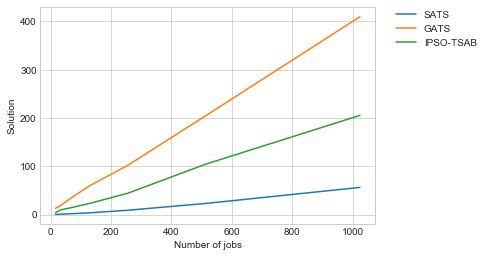

In [30]:
from pylab import *
 
#t = arange(16, 1168, 144)
t = [16,32,64,128,256,512,1024]
s = [.45,.9,1.84,3.68,9.12,23.04,56.32]
s2 = [12.93, 18.514,32.93,59.47,102.32,204.15,409.6]
s3 = [4.32,9.71,13.84,23.10,44.44,104.2,205.4 ]
plot(t, s, label = 'SATS')
plot(t, s2, label = 'GATS')
plot(t, s3, label = 'IPSO-TSAB')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

xlabel('Number of jobs')
ylabel('Solution')
#title('Python Line Chart: Plotting numbers')
grid(True)
show()

In [31]:
#Displaying percentage of non-null values for each selected feature

i = 0;
for col in df2.columns:
    i = i+1;
    print (i-1, col, 100*df2[col].count()/len(df2['case_status']))

0 agent_firm_name 100.0
1 agent_state 100.0
2 case_status 100.0
3 class_of_admission 94.0800408796
4 country_of_citizenship 94.5890703264
5 decision_date 100.0
6 employer_city 99.9971923362
7 employer_country 64.3651310617
8 employer_name 99.997753869
9 employer_num_employees 64.3637272298
10 employer_postal_code 100.0
11 employer_state 100.0
12 employer_yr_estab 64.3477235462
13 job_info_work_city 99.9733271939
14 job_info_work_state 99.9730464275
15 pw_soc_code 99.8905011118
16 pw_source_name_9089 99.4140405651
17 pw_amount_9089_new 100.0


In [51]:
#Replace the values with the mode or mean
df2['class_of_admission']=df2['class_of_admission'].fillna((df2['class_of_admission'].mode()[0]))

df2['country_of_citizenship']=df2['country_of_citizenship'].fillna((df2['country_of_citizenship'].mode()[0]))

df2['employer_city']=df2['employer_city'].fillna((df2['employer_city'].mode()[0]))

df2['employer_name']=df2['employer_name'].fillna((df2['employer_name'].mode()[0]))

df2['job_info_work_city']=df2['employer_name'].fillna((df2['employer_name'].mode()[0]))

df2['job_info_work_state']=df2['employer_name'].fillna((df2['employer_name'].mode()[0]))

df2['job_info_work_state']=df2['employer_name'].fillna((df2['employer_name'].mode()[0]))

df2['pw_source_name_9089']=df2['pw_source_name_9089'].fillna((df2['pw_source_name_9089'].mode()[0]))


df2['pw_soc_code'] = df2['pw_soc_code'].astype(str)
df2['pw_soc_code'] = df2['pw_soc_code'].str.replace('-', '')
df2['pw_soc_code'] = df2['pw_soc_code'].str[0:6]

df2['pw_soc_code']=df2['pw_soc_code'].fillna((df2['pw_soc_code'].mode()[0]))

df2['employer_yr_estab']=df2['employer_yr_estab'].fillna(1700.0)
df2['employer_yr_estab'] = df2['employer_yr_estab'].astype(int)
df2['employer_yr_estab'].value_counts()
df2.loc[df['employer_yr_estab'] < 1700, 'employer_yr_estab'] = 1700

df2['employer_country']=df2['employer_country'].fillna((df2['employer_country'].mode()[0]))

df2['employer_num_employees']=df2['employer_num_employees'].fillna((df2['employer_num_employees'].mean()))


In [52]:
#Displaying percentage of non-null values for each selected feature

i = 0;
for col in df2.columns:
    i = i+1;
    print (i-1, col, 100*df2[col].count()/len(df2['case_status']))

0 agent_firm_name 100.0
1 agent_state 100.0
2 case_status 100.0
3 class_of_admission 100.0
4 country_of_citizenship 100.0
5 decision_date 100.0
6 employer_city 100.0
7 employer_country 100.0
8 employer_name 100.0
9 employer_num_employees 100.0
10 employer_postal_code 100.0
11 employer_state 100.0
12 employer_yr_estab 100.0
13 job_info_work_city 100.0
14 job_info_work_state 100.0
15 pw_soc_code 100.0
16 pw_source_name_9089 100.0
17 pw_amount_9089_new 100.0


In [61]:
#df2['employer_yr_estab'].value_counts()
df2.head()

,agent_firm_name,agent_state,case_status,class_of_admission,country_of_citizenship,decision_date,employer_city,employer_country,employer_name,employer_num_employees,employer_postal_code,employer_state,employer_yr_estab,job_info_work_city,job_info_work_state,pw_soc_code,pw_source_name_9089,pw_amount_9089_new
case_no,,,,,,,,,,,,,,,,,,
A-07323-97014,9941,57,1,28,79,2012,4838,5,43093,22348.571372,1001,40,0,43093,43093,151031,3,75629.0
A-07332-99439,9941,57,0,5,79,2011,1012,5,47833,22348.571372,7072,40,0,47833,47833,474041,3,37024.0
A-07333-99643,9941,57,1,19,79,2011,2614,5,54367,22348.571372,2305,52,0,54367,54367,172051,3,47923.0
A-07339-01930,9941,57,1,5,79,2011,2316,5,18799,22348.571372,1135,40,0,18799,18799,434071,3,22817.6
A-07345-03565,9941,57,1,31,79,2012,46,5,2343,22348.571372,1220,40,0,2343,2343,419031,3,94890.0


In [60]:
le_agent_firm_name = preprocessing.LabelEncoder()
le_agent_firm_name.fit(df2['agent_firm_name'])
df2['agent_firm_name'] = le_agent_firm_name.transform(df2['agent_firm_name'])


#le_ = preprocessing.LabelEncoder()
#le_.fit(df2[''])
#df2[''] = le_.transform(df2[''])


le_class_of_admission = preprocessing.LabelEncoder()
le_class_of_admission.fit(df2['class_of_admission'])
df2['class_of_admission'] = le_class_of_admission.transform(df2['class_of_admission'])


le_country_of_citizenship = preprocessing.LabelEncoder()
le_country_of_citizenship.fit(df2['country_of_citizenship'])
df2['country_of_citizenship'] = le_country_of_citizenship.transform(df2['country_of_citizenship'])

#employer_city
le_employer_city = preprocessing.LabelEncoder()
le_employer_city.fit(df2['employer_city'])
df2['employer_city'] = le_employer_city.transform(df2['employer_city'])

#employer_country
le_employer_country = preprocessing.LabelEncoder()
le_employer_country.fit(df2['employer_country'])
df2['employer_country'] = le_employer_country.transform(df2['employer_country'])

#employer_name
le_employer_name = preprocessing.LabelEncoder()
le_employer_name.fit(df2['employer_name'])
df2['employer_name'] = le_employer_name.transform(df2['employer_name'])

#job_info_work_ciity
le_job_info_work_city = preprocessing.LabelEncoder()
le_job_info_work_city.fit(df2['job_info_work_city'])
df2['job_info_work_city'] = le_job_info_work_city.transform(df2['job_info_work_city'])

#job_info_work_state
le_job_info_work_state = preprocessing.LabelEncoder()
le_job_info_work_state.fit(df2['job_info_work_state'])
df2['job_info_work_state'] = le_job_info_work_state.transform(df2['job_info_work_state'])

#pw_source_name_9089
le_pw_source_name_9089 = preprocessing.LabelEncoder()
le_pw_source_name_9089.fit(df2['pw_source_name_9089'])
df2['pw_source_name_9089'] = le_pw_source_name_9089.transform(df2['pw_source_name_9089'])

In [70]:
X = df2.loc[:, df2.columns != 'case_status']
Y = df2.case_status

In [74]:
X.shape

(356168, 17)

In [75]:
Y.shape

(356168,)

In [95]:
from sklearn.model_selection import StratifiedKFold

#X = np.array([[1,2],[3,4],[1,2],[3,4]])
#y = np.array([0, 0 , 1,1])
skf = StratifiedKFold(n_splits = 2)

for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = Y[train_index], Y[test_index]
    df_train = X.iloc[train_index,:]
    df_test = X.iloc[test_index,:]
    label_train = Y.iloc[train_index]
    label_test = Y.iloc[test_index]
    df_train.head()
    


case_no
A-13315-13701    0
A-13305-09877    0
A-13306-10235    0
A-13303-07176    0
A-14003-30001    0
Name: case_status, dtype: int64

,agent_firm_name,agent_state,case_status,class_of_admission,country_of_citizenship,decision_date,employer_city,employer_country,employer_name,employer_num_employees,employer_postal_code,employer_state,employer_yr_estab,job_info_work_city,job_info_work_state,pw_soc_code,pw_source_name_9089,pw_amount_9089_new
case_no,,,,,,,,,,,,,,,,,,
A-07323-97014,9941,57,1,28,79,2012,4838,5,43093,22348.571372,1001,40,0,43093,43093,151031,3,75629.0
A-07332-99439,9941,57,0,5,79,2011,1012,5,47833,22348.571372,7072,40,0,47833,47833,474041,3,37024.0
A-07333-99643,9941,57,1,19,79,2011,2614,5,54367,22348.571372,2305,52,0,54367,54367,172051,3,47923.0
A-07339-01930,9941,57,1,5,79,2011,2316,5,18799,22348.571372,1135,40,0,18799,18799,434071,3,22817.6
A-07345-03565,9941,57,1,31,79,2012,46,5,2343,22348.571372,1220,40,0,2343,2343,419031,3,94890.0
